# Support Vector Machine: Predicting community membership of Perdiz arrow points

In [1]:
# load analysis packages
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics

# read data
data = pd.read_csv('perdizsite.csv')
data.head()

,spec,site,region,maxl,maxw,maxth,maxstl,maxstw
0,554,41cp12,north,25.40,12.18,3.82,5.75,3.84
1,555,41cp12,north,22.92,12.87,3.54,3.71,3.69
2,556,41cp12,north,24.09,11.87,3.61,5.15,4.78
3,559,41cp12,north,25.01,10.57,3.50,5.84,3.88
4,562,41cp12,north,22.10,10.45,3.47,3.77,3.43


### select features and response

In [2]:
# attributes for analysis
feature_cols = ['maxl', 'maxw', 'maxth', 'maxstl', 'maxstw']
X = data[feature_cols]

# cast from string to int
reg_num = {'north':0, 'south':1}
data['reg_num'] = data.region.map(reg_num)
data.head()
y = data.reg_num

### ensure that features and responses are numeric

In [3]:
X.dtypes

maxl      float64
maxw      float64
maxth     float64
maxstl    float64
maxstw    float64
dtype: object

In [4]:
y.dtypes

dtype('int64')

### split data for train/test

In [5]:
# split data into train/test sets (75/25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 0)

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train:', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (50, 5)
X_test:  (17, 5)
y_train: (50,)
y_test:  (17,)


### decrease sensitivity of algorithm to outliers through standardizing features

In [6]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### create SVM classifier with linear kernel

In [7]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train_std, y_train)

SVC(kernel='linear')

### grid search and nested cross validation of training dataset

In [8]:
# grid search
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state = 0))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = 1)
gs = gs.fit(X_train_std, y_train)
print('Grid Search Best Score: ', gs.best_score_)
print('Grid Search Best Parameters: ', gs.best_params_)
# use the test dataset to estimate model performance
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
clf.score(X_test_std, y_test)

# nested cross validation
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = 1)
scores = cross_val_score(gs, X_train_std, y_train,
                         scoring = 'accuracy',
                         cv = 10)
print('Cross Validation Scores: ', scores)
print('Cross Validation Mean Score: ', scores.mean())


Grid Search Best Score:  0.8600000000000001
Grid Search Best Parameters:  {'clf__C': 10.0, 'clf__kernel': 'linear'}
Cross Validation Scores:  [0.8 1.  0.4 1.  0.8 0.8 1.  1.  0.8 1. ]
Cross Validation Mean Score:  0.8600000000000001


### make predictions + evaluate accuracy

In [9]:
y_pred = clf.predict(X_test_std)
print('Receiver Operator Curve Score: ', roc_auc_score(y_true = y_test,
                                                       y_score = y_pred))
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Receiver Operator Curve Score:  0.96875
Accuracy Score:  0.9411764705882353
Precision:  1.0
Recall:  0.9375


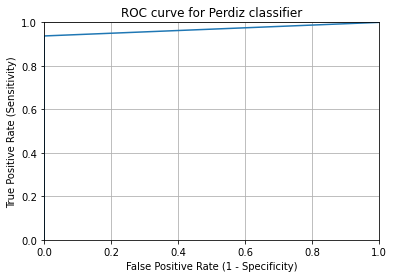

In [10]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Perdiz classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)



